### Imports

In [1]:
import numpy as np

from dicl import dicl, adapters
from dicl.icl import iclearner as icl
from dicl.utils import data_readers

import importlib

importlib.reload(dicl)
importlib.reload(adapters)
importlib.reload(icl)
importlib.reload(data_readers)

/mnt/vdb/abenechehab/conda_envs/adapters2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/vdb/abenechehab/conda_envs/adapters2/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/mnt/vdb/abenechehab/conda_envs/adapters2/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


<module 'dicl.utils.data_readers' from '/mnt/vdb/abenechehab/dicl-adapters/src/dicl/utils/data_readers.py'>

## Load Moment model

In [ ]:
import os

os.environ["HF_HOME"] = "/mnt/vdb/hugguingface/"

from momentfm import MOMENTPipeline

forecast_horizon = 96
model_name = "AutonLab/MOMENT-1-small"
model = MOMENTPipeline.from_pretrained(
    model_name,
    model_kwargs={
        "task_name": "forecasting",
        "forecast_horizon": forecast_horizon,
        "head_dropout": 0.1,
        "weight_decay": 0,
        "freeze_encoder": True,  # Freeze the patch embedding layer
        "freeze_embedder": True,  # Freeze the transformer encoder
        "freeze_head": False,  # The linear forecasting head must be trained
    },
    local_files_only=True,
)
model.init()

/mnt/vdb/abenechehab/conda_envs/adapters2/lib/python3.11/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


## Load data

In [ ]:
env_name = "HalfCheetah"
data_label = "expert"

# ICL parameters
context_length = 512  # 512 mandatory for MOMENT
effective_context_length = context_length + forecast_horizon + 1
n_features = 17

time_series = data_readers.load_rl_data(env_name=env_name, data_label=data_label)
time_series = time_series[:context_length, :n_features]

print(
    f"The in-context trajectory shape is (n_timestamps:{time_series.shape[0]}, "
    f"n_features:{time_series.shape[1]})"
)

In [ ]:
datareader = data_readers.DataReader(
    data_path="/mnt/vdb/abenechehab/dicl-adapters/external_data/",
    transform_ts_size=context_length,
    univariate=False,
)

dataset_name = f"ETTh1_pred={forecast_horizon}"

X_train, y_train = datareader.read_dataset(dataset_name=dataset_name, training_set=True)
X_test, y_test = datareader.read_dataset(dataset_name=dataset_name, training_set=False)

batch_size = -1
time_series = np.concatenate([X_test, y_test], axis=-1)
print(f"original time series shape: {time_series.shape}")
if batch_size > 0:
    time_series = time_series[:batch_size]

n_features = time_series.shape[1]
context_length = time_series.shape[2]

time_series.shape

original time series shape: (2785, 7, 608)


(2785, 7, 608)

## DICL

* Instantiate disentangler (identity or pca)
* Instantiate iclearner (Moment)
* Instantiate DICL

In [ ]:
n_components = int(n_features / 2)
base_projector = "pca"

disentangler = adapters.MultichannelProjector(
    num_channels=n_features,
    new_num_channels=n_components,
    patch_window_size=None,
    base_projector=base_projector,
)

iclearner = icl.MomentICLTrainer(
    model=model, n_features=n_components, forecast_horizon=forecast_horizon
)

DICL = dicl.DICL(
    disentangler=disentangler,
    iclearner=iclearner,
    n_features=n_features,
    n_components=n_components,
)

* Fit disentangler. This can be done using a bigger dataset than the in-context time series.

In [8]:
DICL.fit_disentangler(X=X_train)

### Autoregressive multi-step prediction and visualization

In [9]:
mean, mode, lb, ub = DICL.predict_multi_step(
    X=time_series,
    prediction_horizon=forecast_horizon,
)

In [ ]:
import os
import csv
from pathlib import Path

# print metrics
burnin = 0
metrics = DICL.compute_metrics()
print(metrics)

columns = [
    "dataset",
    "foundational_model",
    "adapter",
    "n_features",
    "n_components",
    "is_fine_tuned",
    "context_length",
    "forecast_horizon",
    "metric",
    "value",
]

data_row = [
    dataset_name,
    model_name,
    base_projector,
    n_features,
    n_components,
    False,
    context_length,
    forecast_horizon,
]

for metric, value in metrics.items():
    data_row.append(metric)
    data_row.append(value)

data_path = Path("/mnt/vdb/abenechehab/dicl-adapters/results/data.csv")

# Check if the file already exists
file_exists = data_path.exists()

# Open the file in append mode if it exists, otherwise create a new file
with open(data_path, "a" if file_exists else "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    # If the file does not exist, write the header
    if not file_exists:
        writer.writerow(columns)
    # Write the data row
    writer.writerow(data_row)

{'mse': 0.4443496778412416, 'mae': 0.4553602393577543, 'scaled_mse': 0.4416218414725927, 'scaled_mae': 0.45569735211896106}


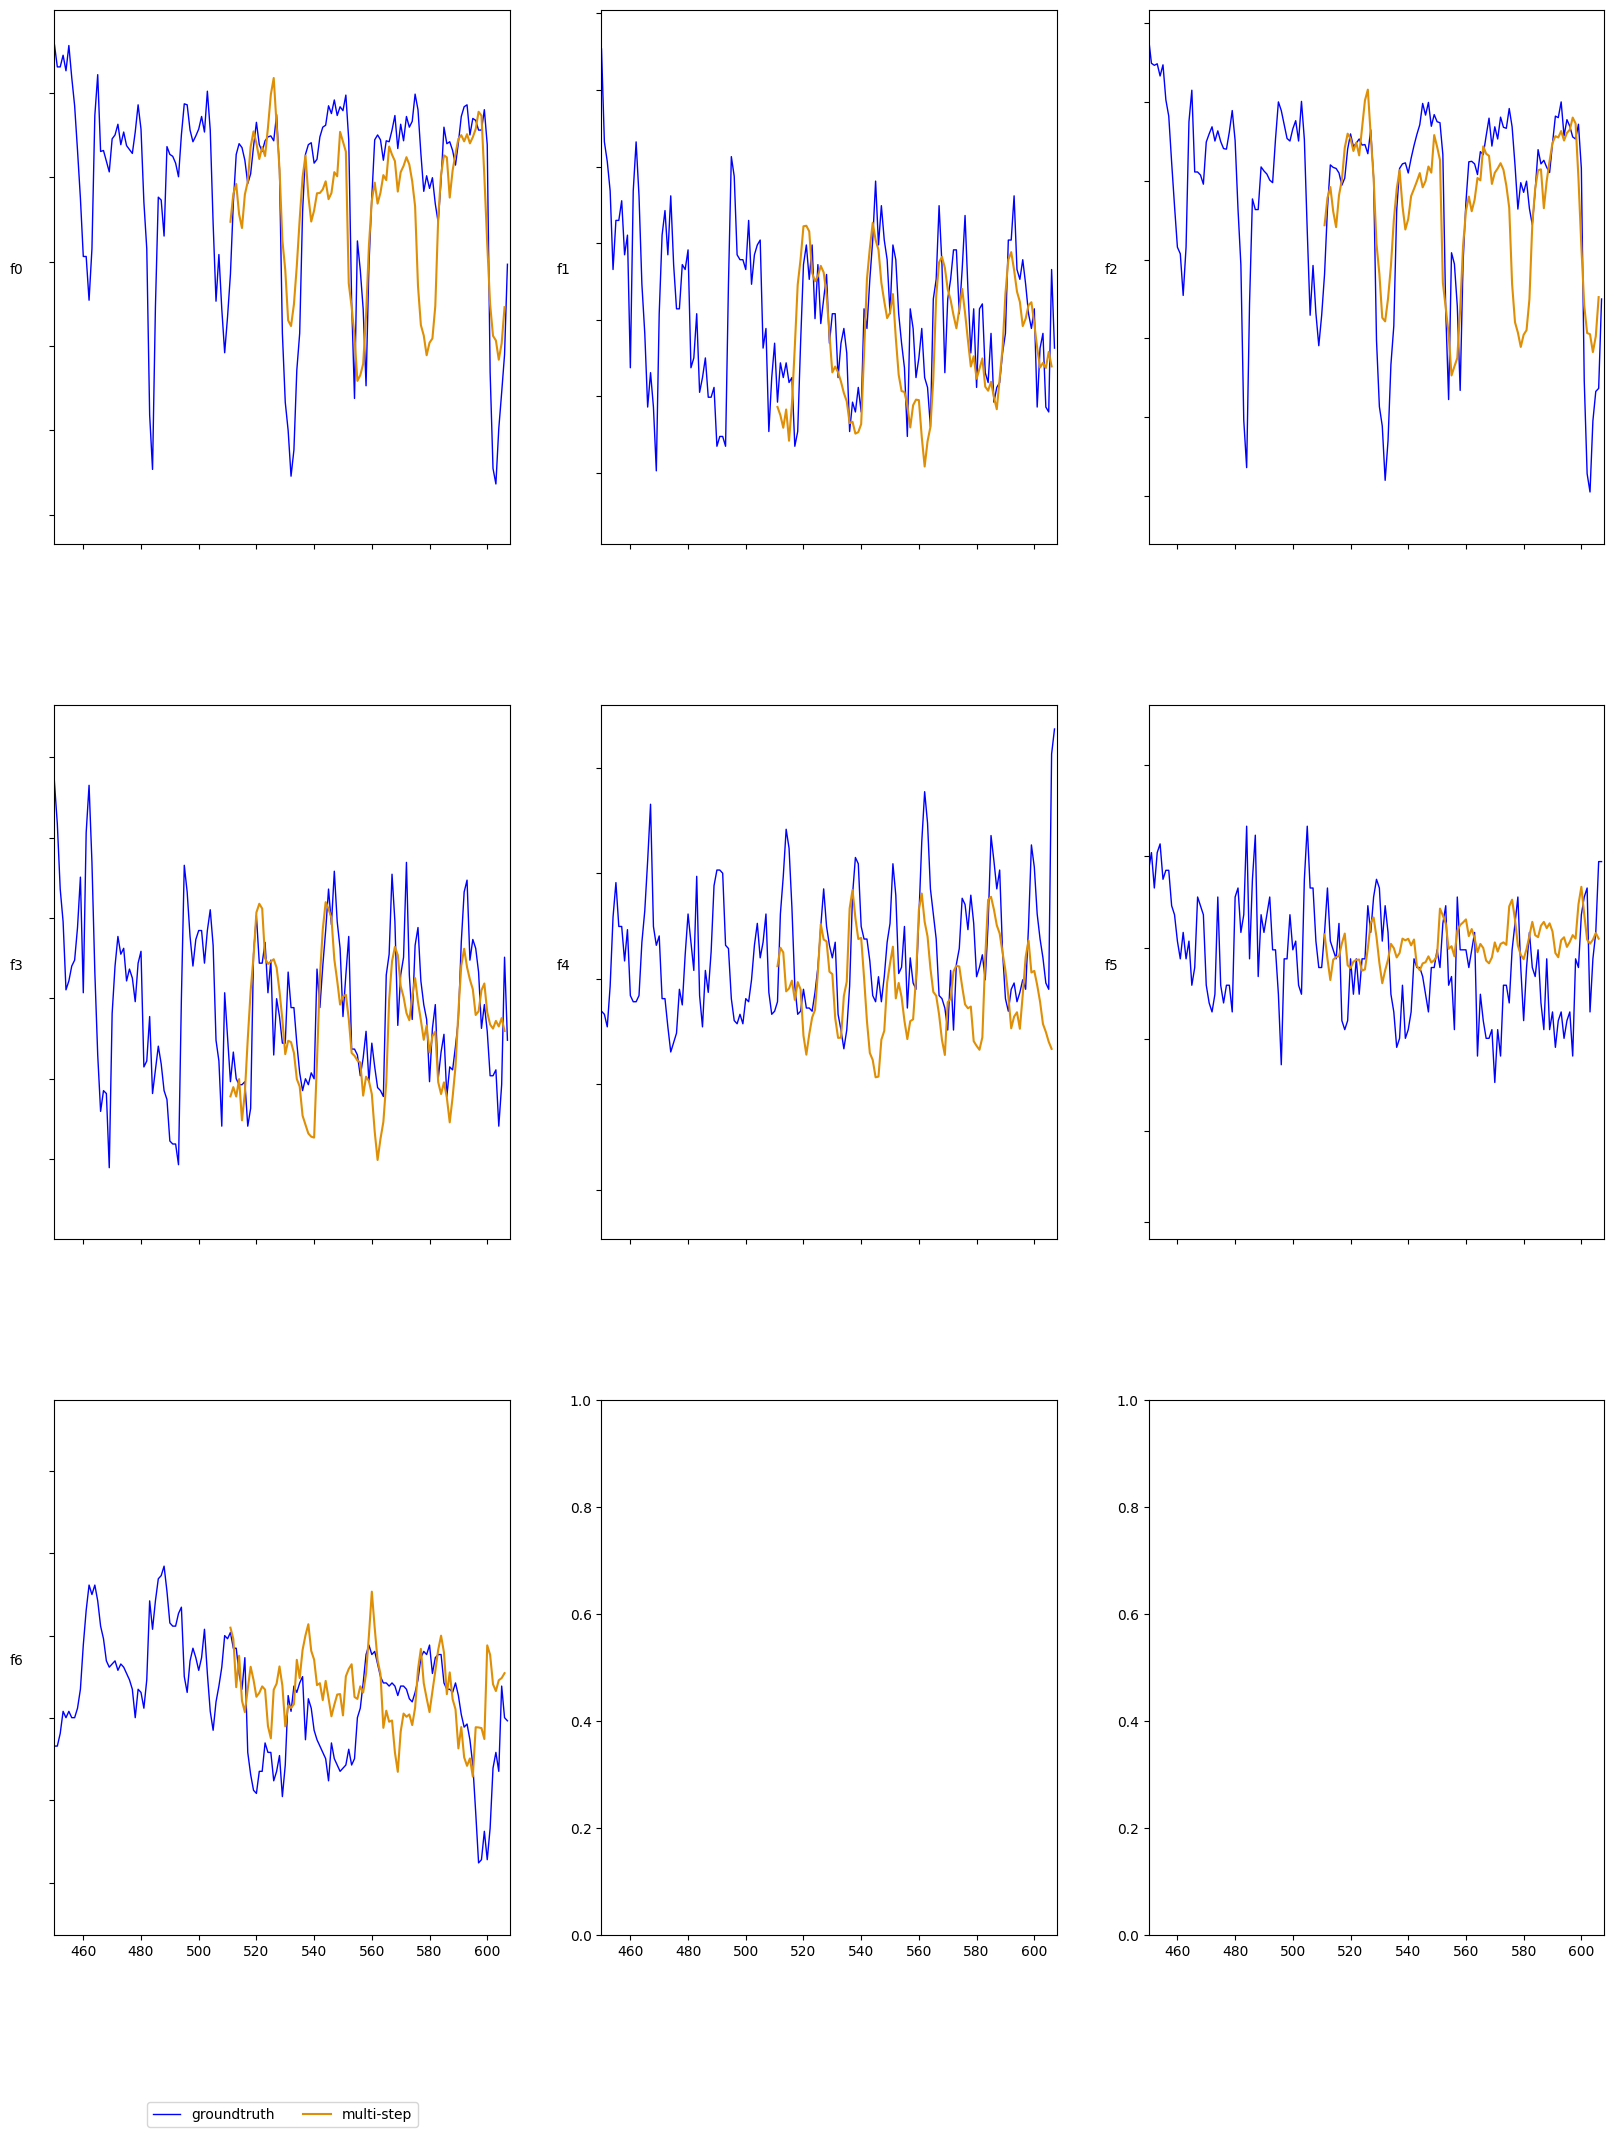

In [16]:
DICL.plot_multi_step(sample=1000, xlim=[450, context_length])

## Fine tuning

In [17]:
DICL.fine_tune_iclearner(
    X=X_train,
    y=y_train,
    n_epochs=1,
    batch_size=8,
    learning_rate=1e-4,
    max_grad_norm=5.0,
    verbose=1,
    seed=13,
)

/mnt/vdb/abenechehab/dicl-adapters/src/dicl/icl/iclearner.py:478: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 0:   0%|          | 0/1005 [00:00<?, ?it/s]/mnt/vdb/abenechehab/dicl-adapters/src/dicl/icl/iclearner.py:497: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/mnt/vdb/abenechehab/conda_envs/adapters2/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **

Epoch 0: Train loss: 0.374


### multi-step prediction after fine tuning

In [ ]:
mean, mode, lb, ub = DICL.predict_multi_step(
    X=time_series,
    prediction_horizon=forecast_horizon,
)

In [19]:
# print metrics
burnin = 0
metrics = DICL.compute_metrics()
print(metrics)

{'mse': 0.4443496778412416, 'mae': 0.4553602393577543, 'scaled_mse': 0.4416218414725927, 'scaled_mae': 0.45569735211896106}
